# 6. BBox Regression Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from dataset import *
from vnet import *
from training import *
from niiutility import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 6.1 Setup Torch Global Variable, load memory map 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 2
NUM_WORKERS = 6
NUM_TRAIN = 279
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

* BvMaskDataset, return image and bbox tuple of 6

In [3]:
#-------------------------LOAD THE DATA SET-------------------------------------------#
regen = False

if regen:
    data_index = np.arange(370) + 1
    data_idnex = np.stack ([np.random.shuffle(data_index[:259]),np.random.shuffle(data_index[259:])])
    print(list(data_index))
else:
    data_index = np.array ([55, 185, 236, 156, 150, 32, 116, 249, 142, 120, 53, 19, 179, 161, 68, 173, 181, 125,
                            183, 113, 69, 149, 196, 123, 22, 48, 233, 70, 28, 89, 86, 225, 180, 208, 223, 155, 97,
                            76, 186, 80, 228, 184, 170, 103, 231, 232, 41, 234, 187, 137, 117, 25, 147, 139, 202,
                            102, 54, 104, 81, 128, 105, 198, 66, 30, 135, 119, 110, 247, 153, 211, 85, 61, 251,
                            50, 93, 2, 239, 6, 101, 122, 3, 136, 212, 10, 46, 82, 51, 188, 190, 15, 7, 206, 248,
                            226, 71, 169, 201, 214, 216, 159, 107, 152, 20, 224, 29, 59, 154, 243, 227, 189, 192,
                            33, 79, 16, 114, 144, 26, 98, 245, 4, 141, 62, 132, 39, 191, 121, 171, 220, 115, 96,
                            126, 24, 176, 75, 252, 194, 112, 197, 134, 218, 127, 158, 235, 67, 210, 178, 258, 177,
                            219, 204, 13, 44, 160, 195, 92, 83, 174, 5, 250, 37, 162, 143, 241, 9, 18, 146, 14, 31,
                            242, 91, 43, 217, 230, 151, 209, 23, 199, 35, 90, 45, 47, 148, 87, 165, 88, 129, 52, 246,
                            193, 73, 108, 17, 111, 124, 99, 109, 140, 130, 100, 240, 229, 237, 253, 94, 72, 34, 238,
                            213, 11, 254, 64, 78, 42, 49, 207, 168, 56, 259, 65, 58, 74, 8, 57, 257, 131, 205, 215, 222,
                            175, 145, 27, 36, 163, 244, 255, 38, 157, 60, 203, 63, 95, 1, 84, 12, 167, 166, 256, 118, 133,
                            200, 221, 172, 40, 182, 138, 77, 21, 106, 164, 343, 342, 303, 284, 317, 319, 313, 362, 275,
                            294, 320, 348, 333, 290, 266, 325, 278, 367, 350, 340, 289, 267, 310, 268, 287, 337, 298,
                            270, 286, 276, 368, 304, 311, 269, 295, 363, 321, 291, 309, 345, 263, 281, 329, 271, 273,
                            352, 323, 360, 283, 297, 338, 300, 344, 366, 261, 358, 302, 369, 292, 315, 364, 306, 361,
                            346, 318, 305, 307, 351, 260, 277, 332, 314, 328, 341, 288, 262, 316, 299, 327, 293, 312,
                            354, 285, 347, 359, 331, 274, 357, 324, 370, 265, 349, 280, 272, 339, 336, 308, 356, 282,
                            330, 296, 334, 365, 335, 301, 264, 353, 279, 326, 355, 322])
    
dataset_trans = DatasetBV(data_index, 
                         transform=transforms.Compose([
                             downSample(4),
                             RandomFilp(0.5),
                             RandomAffine(180, 5, 1)
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

* Print first 4 batch of data
* 3 order = 122.30930733680725
* 2 order = 91.09534621238708
* 1 order = 69.77253293991089
* 0 order = 62.877673387527466


0 torch.Size([2, 1, 64, 64, 64]) torch.Size([2, 6])


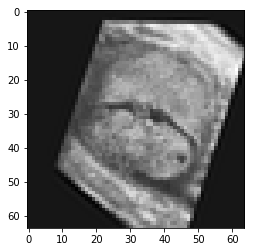

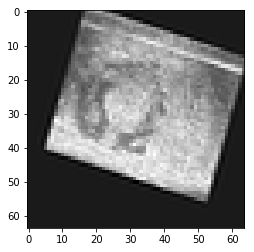

tensor([[30, 53, 35, 46, 33, 50],
        [41, 54, 17, 35, 26, 39]], dtype=torch.int32)
1 torch.Size([2, 1, 64, 64, 64]) torch.Size([2, 6])


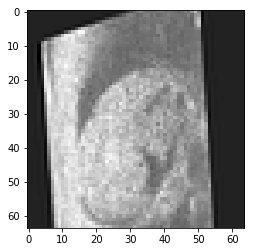

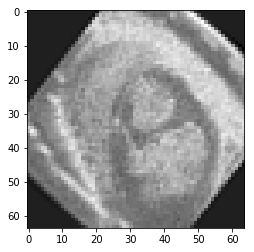

tensor([[23, 41, 18, 33, 25, 47],
        [15, 30, 16, 28, 27, 49]], dtype=torch.int32)
2 torch.Size([2, 1, 64, 64, 64]) torch.Size([2, 6])


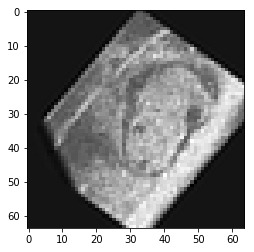

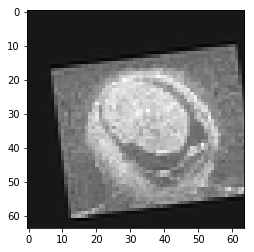

tensor([[19, 40, 29, 46, 31, 42],
        [18, 30, 25, 38, 24, 47]], dtype=torch.int32)
3 torch.Size([2, 1, 64, 64, 64]) torch.Size([2, 6])


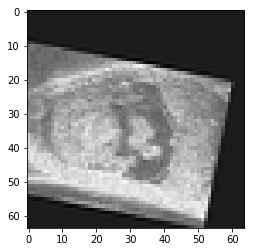

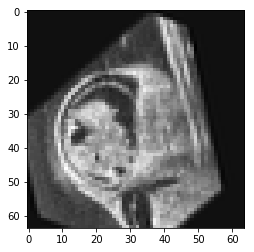

tensor([[ 4, 20, 27, 39, 15, 41],
        [27, 37, 31, 50, 13, 29]], dtype=torch.int32)


In [4]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    show_batch_image(sample_batched['image'],BATCH_SIZE,None)
    print(sample_batched['label'])

    # observe 4th batch and stop.
    if i_batch == 3:
        break

In [5]:
from vnet import LNet

LoadCKP = False

CKPPath = 'checkpoint2019-04-05 19:46:58.793496.pth'

model = LNet(img_size=(64, 64, 64), out_size=6)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=50, verbose=True)
logger = {'train':[], 'validation':[]}

if LoadCKP:
    loadckp(model, optimizer, scheduler, logger, CKPPath, device=device)

In [6]:
#-------------------------NEW MODEL INIT WEIGHT--------------------------------------#

from loss import *

train(model, train_loader, validation_loader, optimizer, scheduler,\
      device=device, dtype=dtype, lossFun=MSE, logger=logger, epochs=5000, startepoch=0)

torch.Size([2, 16, 64, 64, 64])
torch.Size([2, 32, 32, 32, 32])
torch.Size([2, 64, 16, 16, 16])
torch.Size([2, 128, 8, 8, 8])
torch.Size([2, 256, 4, 4, 4])
torch.Size([2, 512, 2, 2, 2])
torch.Size([2, 16, 64, 64, 64])
torch.Size([2, 32, 32, 32, 32])
torch.Size([2, 64, 16, 16, 16])
torch.Size([2, 128, 8, 8, 8])
torch.Size([2, 256, 4, 4, 4])
torch.Size([2, 512, 2, 2, 2])
torch.Size([2, 16, 64, 64, 64])
torch.Size([2, 32, 32, 32, 32])
torch.Size([2, 64, 16, 16, 16])
torch.Size([2, 128, 8, 8, 8])
torch.Size([2, 256, 4, 4, 4])


KeyboardInterrupt: 

In [ ]:
#-------------------------SAVE THE MODEL STATE DICT----------------------------------#
PATH = 'LNET-404.pth'
torch.save(model.state_dict(), PATH)